# Bayesian Exploration
Here we demonstrate the use of Bayesian Exploration to characterize an unknown
function in the presence of constraints (see [here](https://www.nature.com/articles/s41467-021-25757-3)).
The function we wish to explore is the first objective of the TNK test problem.

## Specifiying generator options
We start with the generator defaults and modify as needed for conservative
exploration, which should prevent any constraint violations.

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import torch
import yaml
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)

# can only explore one objective
del vocs.objectives["y2"]

generator_options = BayesianExplorationGenerator.default_options()
generator_options.optim.num_restarts = 20
generator_options.optim.raw_samples = 20
generator_options.optim.max_travel_distances = [0.25, 0.25]
generator_options.optim.use_nearby_initial_points = False
generator_options.model.kwargs.use_conservative_prior_mean = True
generator_options.model.kwargs.use_conservative_prior_lengthscale = False
generator_options.model.kwargs.use_low_noise_prior = True

evaluator = Evaluator(function=evaluate_TNK)
generator = BayesianExplorationGenerator(vocs, generator_options)

print(yaml.dump(generator.options.dict()))

acq:
  monte_carlo_samples: 128
  proximal_lengthscales: null
  use_transformed_proximal_weights: true
model:
  function: !!python/name:xopt.generators.bayesian.models.standard.create_standard_model ''
  kwargs:
    use_conservative_prior_lengthscale: false
    use_conservative_prior_mean: true
    use_low_noise_prior: true
n_initial: 3
optim:
  max_travel_distances:
  - 0.25
  - 0.25
  num_restarts: 20
  raw_samples: 20
  sequential: true
  use_nearby_initial_points: false



## Run exploration
We start with evaluating 2 points that we know satisfy the constraints. We then run
30 exploration steps.

In [2]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.7, 0.95]}))

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,1.00,0.70,1.00,0.70,0.584045,0.290,"[1, 2, 3]",0.000029,False
2,0.75,0.95,0.75,0.95,0.494833,0.265,"[1, 2, 3]",0.000012,False


In [3]:
for i in range(10):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


In [4]:
# view the data
X.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.700000,1.000000,0.700000,0.584045,0.290000,"[1, 2, 3]",0.000029,False,NaN
2,0.750000,0.950000,0.750000,0.950000,0.494833,0.265000,"[1, 2, 3]",0.000012,False,NaN
3,0.701105,1.097199,0.701105,1.097199,0.790089,0.397089,"[1, 2, 3]",0.000020,False,dummy_constant
4,0.589996,0.993096,0.589996,0.993096,0.400506,0.251242,"[1, 2, 3]",0.000020,False,dummy_constant
5,0.300538,1.080049,0.300538,1.080049,0.292994,0.376242,"[1, 2, 3]",0.000027,False,dummy_constant
6,0.943344,0.493089,0.943344,0.493089,0.118321,0.196601,"[1, 2, 3]",0.000026,False,dummy_constant
7,1.138701,0.478127,1.138701,0.478127,0.425545,0.408418,"[1, 2, 3]",0.000024,False,dummy_constant
8,0.992482,0.927652,0.992482,0.927652,0.759788,0.425425,"[1, 2, 3]",0.000022,False,dummy_constant
9,0.442430,1.149987,0.442430,1.149987,0.426378,0.425798,"[1, 2, 3]",0.000032,False,dummy_constant
10,0.427763,0.932219,0.427763,0.932219,-0.030517,0.192031,"[1, 2, 3]",0.000019,False,dummy_constant


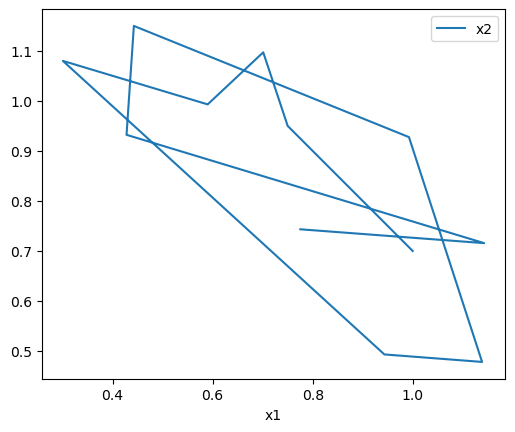

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

## Introspect models
During exploration we generate Gaussian Process models of each objective and
constraint. We demonstrate how they are viewed below.

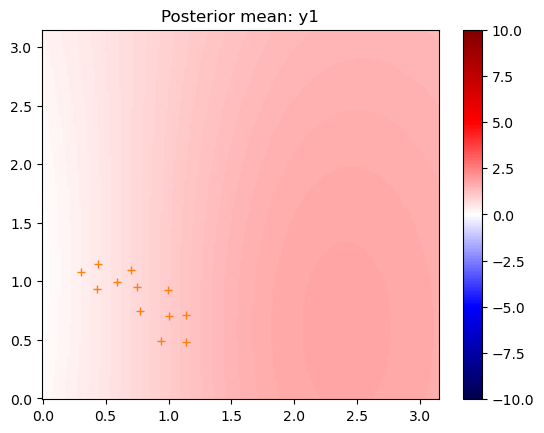

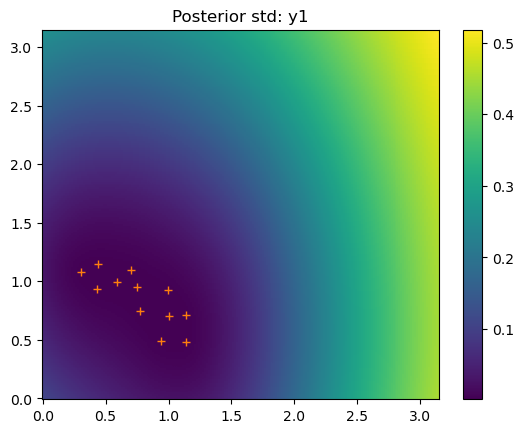

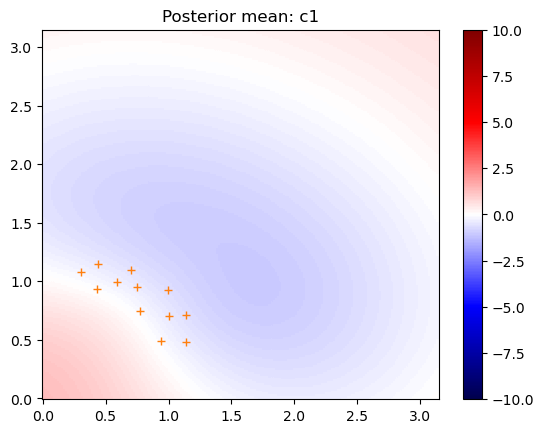

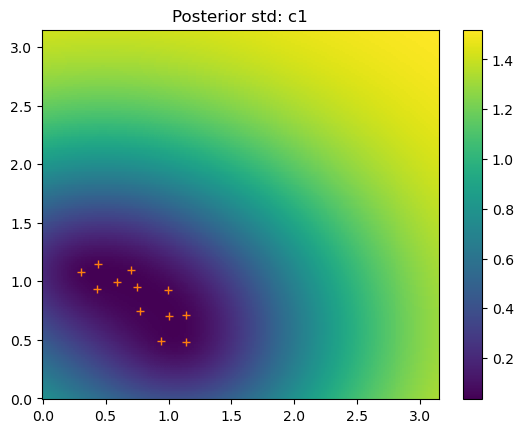

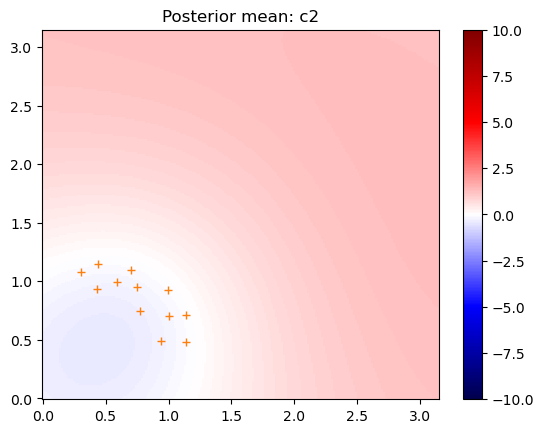

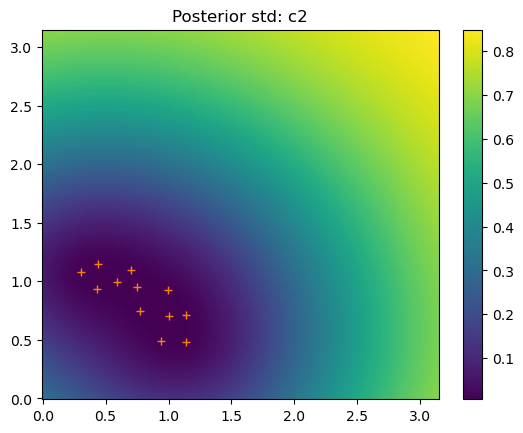

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    std = torch.sqrt(post.variance)

    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n), cmap="seismic",vmin=-10.0,
                      vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

        fig2, ax2 = plt.subplots()
        ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax2.pcolor(xx, yy, std[:, i].reshape(n, n))
        fig2.colorbar(c)
        ax2.set_title(f"Posterior std: {outputs[i]}")

## View acquisition function and feasibility prediction

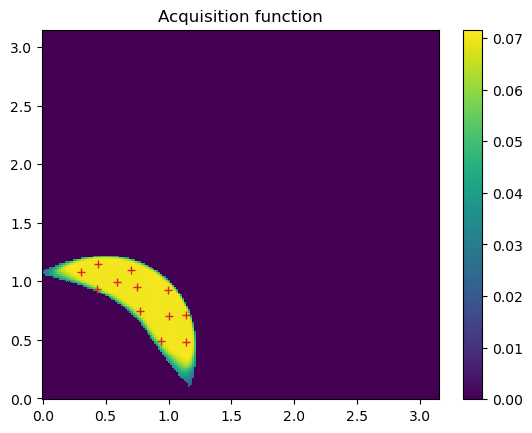

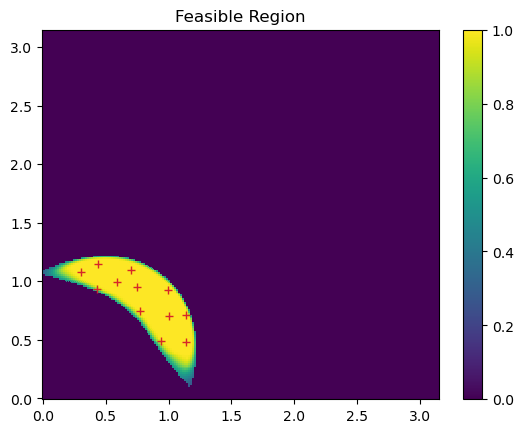

In [7]:
from xopt.generators.bayesian.utils import feasibility

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

## Generator model hyperparameters

In [8]:
# print generator model hyperparameters
for name, val in X.generator.model.named_parameters():
    print(f"{name}:{val}")

X.generator.model.models[2].covar_module.base_kernel.lengthscale

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-27.1665], dtype=torch.float64, requires_grad=True)
models.0.mean_module.raw_constant:-0.11149532167466615
models.0.covar_module.raw_outputscale:5.236984945526396
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.0444,  0.8259]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-5.4732], dtype=torch.float64, requires_grad=True)
models.1.mean_module.raw_constant:1.0
models.1.covar_module.raw_outputscale:2.30461125963907
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.3275, -0.5559]], dtype=torch.float64, requires_grad=True)
models.2.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-24.3870], dtype=torch.float64, requires_grad=True)
models.2.mean_module.raw_constant:1.0
models.2.covar_module.raw_outputscale:0.2537013222490131
models.2.covar_module.base_kernel.raw_lengthsc

tensor([[0.6209, 0.6072]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)

## Examine the number of constraint violations
Using the convience function provided by the vocs object we can evaluate which
samples violate either or both of our constraints.

In [9]:
X.vocs.feasibility_data(X.data)

,feasible_c1,feasible_c2,feasible
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True
10,False,True,False


In [10]:
# generate next point
X.generator.generate(1)

,x1,x2,a
0,0.859083,1.081526,dummy_constant
